<a href="https://colab.research.google.com/github/TonmoyTalukder/deep-learning-explore/blob/main/PyTorch_Explore/6_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ImageFolder
# Scheduler
# Transfer Learning

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [2]:
# download dataset
import urllib.request
import zipfile

url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
filename, headers = urllib.request.urlretrieve(url, "hymenoptera_data.zip")

# download kalpurush.ttf
url = "https://github.com/MohammadTaseenKhan/Fonts-Hub/blob/main/kalpurush.ttf?raw=true"
filename, headers = urllib.request.urlretrieve(url, "kalpurush.ttf")

# download test image
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRNMrk-6vlhpV3PnUH1GddpDVNqWQjoGON3aQ&usqp=CAU"
filename, headers = urllib.request.urlretrieve(url, "ant.jpg")

In [3]:
# Zip Extractor
from zipfile import ZipFile, BadZipFile
import os
def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)
        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)
    except BadZipFile as e:
        print("Error:", e)

extract_file_path = "./hymenoptera_data"
extract_zip_file(extract_file_path)

In [4]:
data_dir = './hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes
print(class_names)

class_names = ['পিঁপড়া' if name == 'ants' else 'মৌমাছি' for name in class_names]
print(class_names) # পিঁপড়া মৌমাছি

['ants', 'bees']
['পিঁপড়া', 'মৌমাছি']


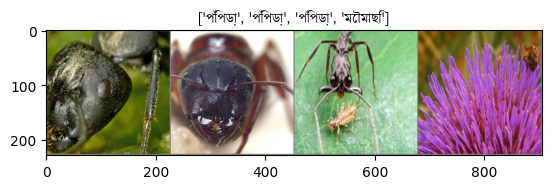

In [5]:
from matplotlib.font_manager import FontProperties

# Define the path to your Bengali font file (.ttf)
bengali_font_path = '/content/kalpurush.ttf'
# Create a FontProperties object for the Bengali font
bengali_font = FontProperties(fname=bengali_font_path)

def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title, fontproperties=bengali_font)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Convert class indices to class names in Bengali
class_names = [class_names[x] for x in classes]

imshow(out, title=class_names)

In [ ]:
# def imshow(inp, title):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     plt.title(title)
#     plt.show()


# # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# print(f'\n{num_ftrs}')

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2) # Because we have two classes

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Scheduler: update the learning rate
    # StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
    # Decay LR by a factor of 0.1 every 7 epochs
    # Learning rate scheduling should be applied after optimizer’s update
    # e.g., you should write your code this way:
    # for epoch in range(100):
    #     train(...)
    #     validate(...)
    #     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=2)
torch.save(model.state_dict(), 'saved_model1.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 86.4MB/s]


Epoch 0/1
----------
train Loss: 0.6520 Acc: 0.6107
val Loss: 0.4993 Acc: 0.7516

Epoch 1/1
----------
train Loss: 0.5511 Acc: 0.7459
val Loss: 0.3640 Acc: 0.9085

Training complete in 2m 53s
Best val Acc: 0.908497


In [9]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=2)

torch.save(model_conv.state_dict(), 'saved_model2.pth')

Epoch 0/1
----------
train Loss: 0.7013 Acc: 0.6516
val Loss: 0.2634 Acc: 0.9085

Epoch 1/1
----------
train Loss: 0.4917 Acc: 0.7910
val Loss: 0.2158 Acc: 0.9346

Training complete in 1m 40s
Best val Acc: 0.934641


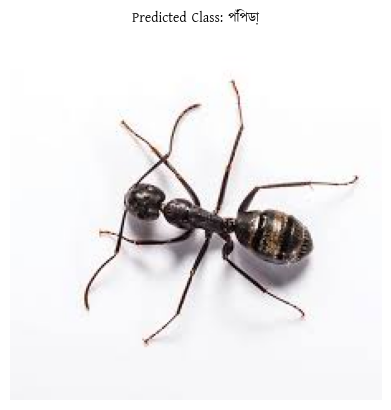

Predicted Class: পিঁপড়া


In [10]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Define the path to your Bengali font file (.ttf)
bengali_font_path = './kalpurush.ttf'
# Create a FontProperties object for the Bengali font
bengali_font = FontProperties(fname=bengali_font_path)

# Load the saved model's state dictionary
model.load_state_dict(torch.load('saved_model1.pth'))
model.eval()

model_conv.load_state_dict(torch.load('saved_model2.pth'))
model_conv.eval()

# Define transformations for input image
    # input_transforms = transforms.Compose([
    #     transforms.Resize(256),
    #     transforms.CenterCrop(224),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean, std)
    # ])
input_transforms = data_transforms['val']

# Load and preprocess the input image
input_image_path = '/content/ant.jpg'  # Provide the path to your input image
# input_image_path = '/content/445356866_6cb3289067.jpg'  # Provide the path to your input image
input_image = Image.open(input_image_path)
input_tensor = input_transforms(input_image)
input_tensor = input_tensor.unsqueeze(0)  # Add a batch dimension

# Move the input tensor to the appropriate device (CPU or GPU)
input_tensor = input_tensor.to(device)

# Make the prediction Model 1
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted_class = torch.max(outputs, 1)

# Get the class name from class_names list
predicted_class_name = class_names[predicted_class.item()]

# Display the input image
plt.imshow(input_image)
# plt.title(f'Predicted Class: {predicted_class_name}')
plt.title(f'Predicted Class: {predicted_class_name}', fontproperties=bengali_font)
plt.axis('off')
plt.show()

print(f'Predicted Class: {predicted_class_name}')

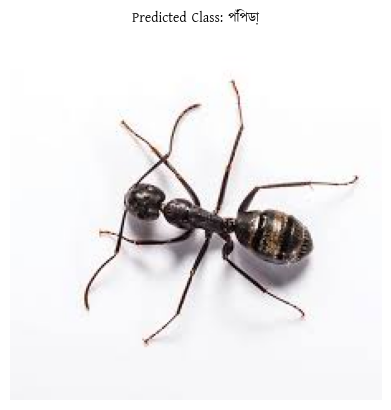

Predicted Class: পিঁপড়া


In [12]:
# Make the prediction Model 2
with torch.no_grad():
    outputs = model_conv(input_tensor)
    _, predicted_class = torch.max(outputs, 1)

# Get the class name from class_names list
predicted_class_name = class_names[predicted_class.item()]

# Display the input image
plt.imshow(input_image)
# plt.title(f'Predicted Class: {predicted_class_name}')
plt.title(f'Predicted Class: {predicted_class_name}', fontproperties=bengali_font)
plt.axis('off')
plt.show()

print(f'Predicted Class: {predicted_class_name}')